In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data.zip'

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

# Part-1

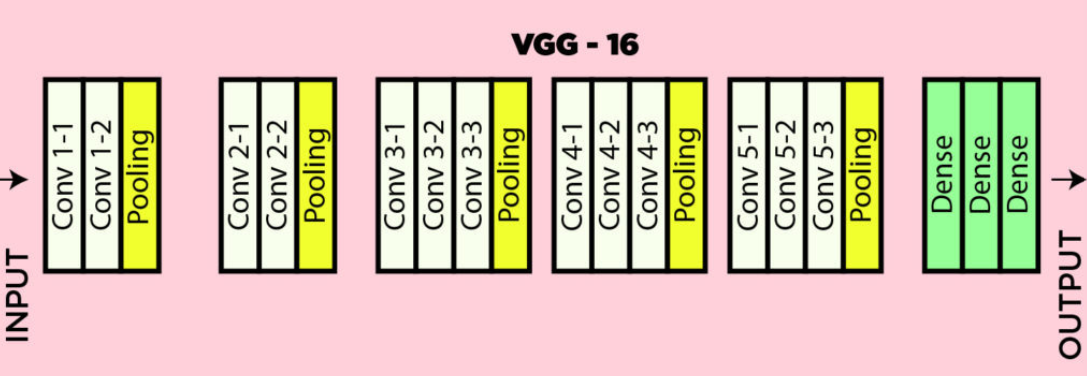

In [ ]:
vgg = VGG16(
    weights='imagenet',
    include_top = True,
    input_shape=(224, 224, 3)
)

In [ ]:
for layer in vgg.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

In [ ]:
vgg.summary()

## Type Finetuning-1

In [ ]:
model = Sequential()
model.add(vgg)
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# It is from Functional API
# x = vgg.layers[-2].output
# output = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=vgg.input, outputs=output)
# model.summary()

In [2]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/data/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224, 224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/data/val',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224, 224)
)

NameError: name 'keras' is not defined

In [ ]:
train_ds

In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

In [ ]:
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
train_ds

In [ ]:
from tensorflow import keras

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds,epochs=3,validation_data=validation_ds,verbose=1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Path to one test image
img_path = 'data/test/cat.jpg'

In [ ]:
# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalization (same as training)

In [ ]:
# Predict
prediction = model.predict(img_array)

# Interpret result
label = "Dog " if prediction[0][0] > 0.5 else "Cat 🐱"
confidence = prediction[0][0]

In [ ]:
# Show result
plt.imshow(img)
plt.title(f"{label} ({confidence:.2f})")
plt.axis('off')
plt.show()


## Type Finetuning-2

In [3]:
vgg_conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224, 224, 3)
)

NameError: name 'VGG16' is not defined

In [ ]:
for layer in vgg_conv_base.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

In [ ]:
vgg_conv_base.summary()

In [ ]:
model = Sequential()
model.add(vgg_conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Part-3

In [4]:
vgg_conv_base.trainable = False
set_trainable = False

NameError: name 'vgg_conv_base' is not defined

In [ ]:
vgg_conv_base.trainable

In [ ]:
vgg_conv_base.layers

In [ ]:
for layer in vgg_conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
for layer in vgg_conv_base.layers:
    print(f"{layer.name:<20} | Type: {type(layer).__name__:<20} | Trainable: {layer.trainable}")

In [ ]:
model = Sequential()
model.add(vgg_conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Lets understand Transfer Learning and Finetuning with BERT now.

In [10]:
!pip install transformers datasets

In [9]:
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer, BertForSequenceClassification
from transformers import BertModel


KeyboardInterrupt: 

In [ ]:
# Load dataset (you can replace this with your CSV)
dataset = load_dataset("imdb", split='train[:2000]')
dataset = dataset.train_test_split(test_size=0.2)
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['test']['text']
val_labels = dataset['test']['label']

In [5]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

NameError: name 'BertTokenizer' is not defined

In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['text'], padding="max_length", truncation=True), batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# Load pre-trained model with new output head
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2  # For binary classification
)

In [ ]:
for param in model.bert.parameters():
    # param.requires_grad = False
    print(len(param))


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


In [6]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


NameError: name 'model' is not defined

In [ ]:
for name, param in model.named_parameters():
    print(f"{name:50} | Shape: {tuple(param.shape)} | Trainable: {param.requires_grad}")


In [ ]:
print(model.bert.embeddings)                 # Embedding layer
print(model.bert.encoder.layer[11])          # Last Transformer block
print(model.classifier)                      # Output classification head


In [ ]:
print(model)  # Full model architecture, all layers


In [7]:
print(model.config)  # Model config: hidden size, num labels, dropout, etc.

NameError: name 'model' is not defined

In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./bert_output_1",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
     report_to="none"
)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)


In [ ]:



trainer.train()


# unfreeze couple of last layer then train it


In [ ]:
from transformers import BertModel, BertTokenizer, PreTrainedModel, Trainer, TrainingArguments, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput

In [ ]:
class BertBinaryClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(config.hidden_size, 2)  # Binary classification logits

        # Freeze all layers
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last 2 layers
        for layer in self.bert.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze pooler
        for param in self.bert.pooler.parameters():
            param.requires_grad = True

        # Classifier should be trainable
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )


In [8]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
model = BertBinaryClassifier(config)

training_args = TrainingArguments(
    output_dir="./bert_last2layers_finetune",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    report_to="none",  # Disable wandb etc.
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

trainer.train()

NameError: name 'BertConfig' is not defined

In [ ]:
def predict_text(text, model, tokenizer):
    # Preprocess input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][predicted_class].item()

    label_name = "Positive ✅" if predicted_class == 1 else "Negative ❌"
    print(f"Text: {text}")
    print(f"Prediction: {label_name} (Confidence: {confidence:.2f})")
    return predicted_class, confidence
